In [216]:
# read cities.txt (id, lat, lon) and plot every city on a map
import matplotlib.pyplot as plt
import numpy as np
from math import radians, cos, sin, sqrt, atan2
import networkx as nx
import pandas as pd
import os, time, sys, random, math

## Part 1: Get Data

In [217]:
# read us-cities-top-1k.csv
df = pd.read_csv('us-cities-top-1k.csv') # cols = ['City', 'State', 'Population', 'lat', 'lon']
# sort by population
df = df.sort_values(by='Population', ascending=False)

with open('cities.txt', 'w') as f:
    for idx, (i, row) in enumerate(df.iterrows()):
        f.write(f'{row["City"].replace(" ", "_")} {row["lat"]:.2f} {row["lon"]:.2f} {row["Population"]}\n')
        # if idx > 10000:
        #     break

In [218]:
def read_cities(filename):
    with open(filename, "r") as f:
        lines = f.readlines()
    cities = []
    for line in lines:
        name, lat, lon, pop = line.split()
        cities.append((name, float(lat), float(lon), int(pop)))
    print(f"Read {len(cities)} cities from {filename}")
    return cities

def remove_outliers(cities):
    lats = [x[1] for x in cities]
    lons = [x[2] for x in cities]
    lat_mean = np.mean(lats)
    lat_std = np.std(lats)
    lon_mean = np.mean(lons)
    lon_std = np.std(lons)
    cities = list(filter(lambda x: abs(x[1] - lat_mean) < 3 * lat_std and abs(x[2] - lon_mean) < 3 * lon_std, cities))
    return cities

def map_range(x, in_min, in_max, out_min, out_max):
  return (x - in_min) * (out_max - out_min) // (in_max - in_min) + out_min

def plot_cities(cities):
    lats, lons, pops = zip(*[(x[1], x[2], x[3]) for x in cities])
    min_pop, max_pop = min(pops), max(pops)
    norm_pops = [map_range(pop, min_pop, max_pop, 1, 100) for pop in pops]
    plt.scatter(lons, lats, s=norm_pops, c="red")  # Using scatter for variable markersize
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("City Plot")
    plt.show()
    

Read 1000 cities from cities.txt


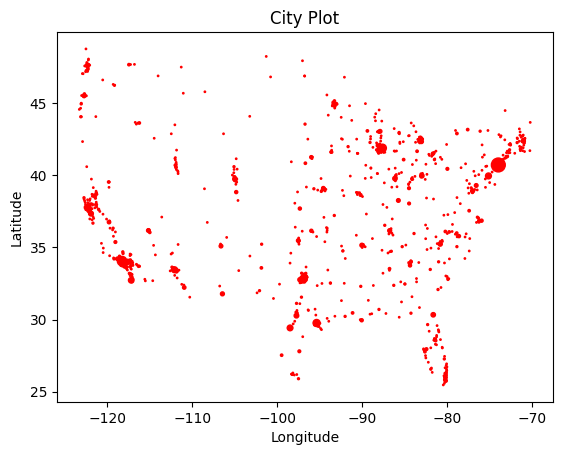

In [219]:
cities = read_cities("cities.txt")
cities = remove_outliers(cities)
plot_cities(cities)

In [220]:
def distance(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c # distance in km

# Determine how redundant each city is based on other cities
def redundancy_1(cities, weight=2):
    r = [0] * len(cities)
    for i in range(len(cities)):
        for j in range(i + 1, len(cities)):
            ci = cities[i]
            cj = cities[j]
            lat1, lon1 = ci[1], ci[2]
            lat2, lon2 = cj[1], cj[2]
            d = distance(lat1, lon1, lat2, lon2)
            p1, p2 = ci[3], cj[3]
            rscore = p2 / p1 * d ** -weight
            if p1 > p2:
                r[j] += rscore
            elif p2 > p1:
                r[i] += rscore
    return r
    

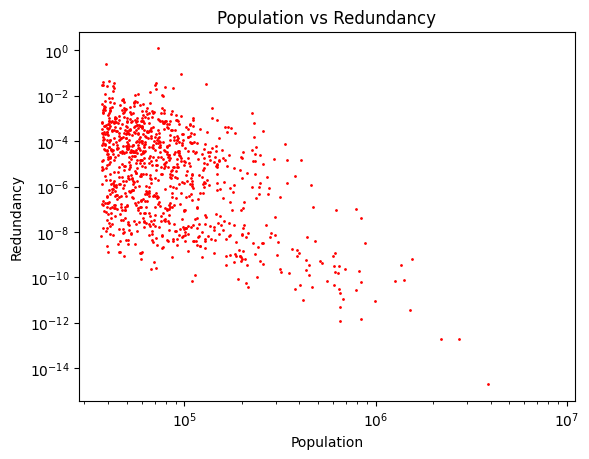

In [221]:
# keep the 100 most redundant cities
scores = redundancy_1(cities, 4)
pops = [x[3] for x in cities]
# plot graph between redundancy and population
plt.scatter(pops, scores, c="red", s=1)
plt.xlabel("Population")
plt.ylabel("Redundancy")
plt.yscale("log")
plt.xscale("log")
plt.title("Population vs Redundancy")
plt.show()

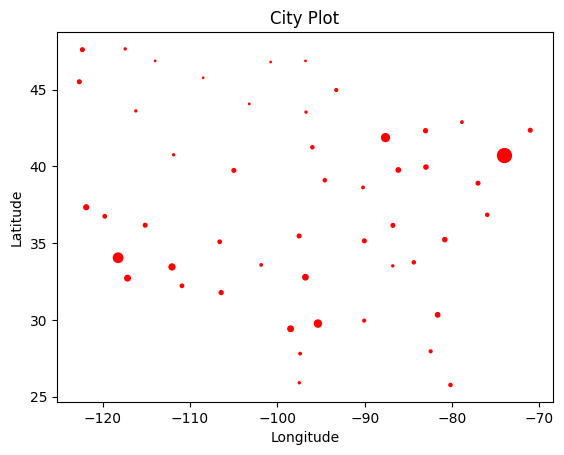

In [251]:
# keep the 100 least redundant cities
cities1 = [cities[i] for i in np.argsort(scores)[:50]]
plot_cities(cities1)

## Part 2: Algorithm

In [252]:
cities1[:5]

[('New_York', 40.71, -74.01, 8405837),
 ('Los_Angeles', 34.05, -118.24, 3884307),
 ('Houston', 29.76, -95.37, 2195914),
 ('Chicago', 41.88, -87.63, 2718782),
 ('Seattle', 47.61, -122.33, 652405)]

In [253]:
# get path length
def path_length(cities, p):
    length = 0
    for i in range(len(p) - 1):
        c1 = cities[p[i]]
        c2 = cities[p[i + 1]]
        length += distance(c1[1], c1[2], c2[1], c2[2])
    return length

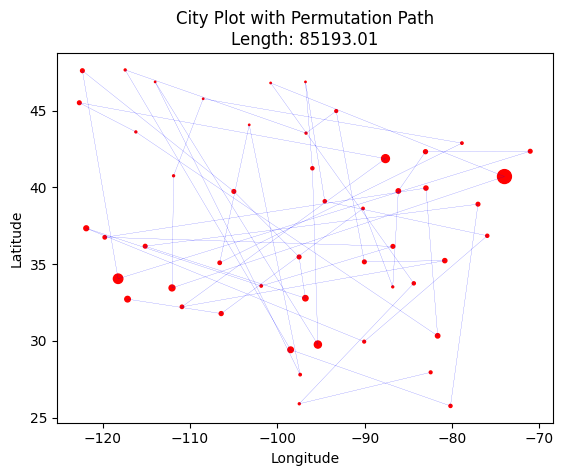

In [254]:
def plot_cities_permutation(cities, p):
    # get path length
    length = path_length(cities, p)
    # Extract cities in the order specified by permutation p
    permuted_cities = [cities[i] for i in p]
    lats, lons, pops = zip(*[(x[1], x[2], x[3]) for x in permuted_cities])
    min_pop, max_pop = min(pops), max(pops)
    norm_pops = [map_range(pop, min_pop, max_pop, 1, 100) for pop in pops]
    
    # Plot the cities as points
    plt.scatter(lons, lats, s=norm_pops, c="red")
    
    # Connect the cities in the order specified by permutation p
    plt.plot(lons, lats, linestyle='-', color='blue', linewidth=0.1)
    
    # Adding labels and title
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"City Plot with Permutation Path\nLength: {length:.2f}")
    plt.show()

p = np.random.permutation(len(cities1))
plot_cities_permutation(cities1, p)

In [257]:
def ordered_crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))
    child = [None] * size
    child[start:end] = parent1[start:end]
    ptr = end
    for i in range(size): 
        if parent2[(end + i) % size] not in child:
            child[ptr % size] = parent2[(end + i) % size]
            ptr += 1
    return child

def mutate(permutation, mutation_rate=0.01):
    for i in range(len(permutation)):
        if random.random() < mutation_rate:
            j = random.randint(0, len(permutation) - 1)
            permutation[i], permutation[j] = permutation[j], permutation[i]

def genetic_algorithm(cities, population_size=100, generations=500, mutation_rate=0.01):
    # Initialize population
    population = [np.random.permutation(len(cities)) for _ in range(population_size)]
    
    for generation in range(generations):
        # Calculate fitness
        fitness = [path_length(cities, p) for p in population]
        print(f"Generation {generation + 1}/{generations} (Fitness: {min(fitness):.2f} - {max(fitness):.2f} - {np.mean(fitness):.2f})",end="\r")
        sorted_indices = np.argsort(fitness)
        population = [population[i] for i in sorted_indices]

        # Selection
        new_population = population[:population_size // 2]
        
        # Crossover
        while len(new_population) < population_size:
            parents = random.sample(new_population, 2)
            child = ordered_crossover(parents[0], parents[1])
            new_population.append(child)

        # Mutation
        for individual in new_population:
            mutate(individual, mutation_rate)

        population = new_population

    # Return the best solution found
    best_solution = population[0]
    best_length = path_length(cities, best_solution)
    return best_solution, best_length

# Run the genetic algorithm
best_permutation, best_length = genetic_algorithm(cities1, mutation_rate=1e-3, generations=2000)

# Plot the best path found
plot_cities_permutation(cities1, best_permutation)

KeyboardInterrupt: 